# Experiment using shortest path error as reward and compare with QR PCA

In [1]:
import kneed

In [1]:
import pandas as pd
import numpy as np
import random

import xlsxwriter
import matplotlib.pyplot as plt 
from scipy.stats import rankdata
from numpy.linalg import pinv
from numpy.linalg import inv
from scipy import linalg as LA

In [2]:
tt=pd.read_csv('C:\\Users\\phamhoad\Desktop\\Research\\SegmentWiseSpeeds_WithObstruction_DesiredFormat.csv',header=None,low_memory=False)
ttime=tt.fillna(0.9*130)
ttime =ttime.replace(0,0.1)
data =np.array(ttime)

X = 25/1000/data*3600


In [3]:
current_node = pd.read_csv('C:\\Users\\phamhoad\Desktop\\Research\\curr_node.csv',header=0,low_memory=False)

In [4]:
connect_node = pd.read_csv('C:\\Users\\phamhoad\Desktop\\Research\\con_node.csv',header=0,low_memory=False)

In [5]:
linknodelist ={}
for i in range(8000):
    linknodelist[(current_node['0'][i],connect_node['0'][i])]=i

In [6]:

def getnext(curr_node,con_node,cur_node):
    nextnodes=[]
    for i in np.arange(len(con_node)):
        if curr_node[i]== cur_node :
            nextnodes.append(con_node[i])
    return nextnodes

In [7]:
cnnlist =pd.read_csv('C:\\Users\\phamhoad\Desktop\\Research\\nextnodelist8kl.csv',header=0,low_memory=False)

In [8]:
arry={i:[] for i in range(len(cnnlist['0']))}
j=0
for i in range(len(cnnlist['0'])):
    a=[]
    for k in cnnlist['0'][i][2:-2].split(','): a.append(int(k))
    
    arry[i].append(a)
    j=j+1
nextnodelist8kl=pd.Series(data=arry, index=np.arange(len(cnnlist['0'])))

In [9]:
nextnodelist8kl

0       [[1173, 2818]]
1       [[1171, 2819]]
2       [[3229, 2820]]
3       [[3230, 2821]]
4       [[3231, 2822]]
             ...      
3980     [[1155, 765]]
3981     [[463, 2181]]
3982      [[225, 770]]
3983      [[226, 771]]
3984     [[470, 2187]]
Length: 3985, dtype: object

In [10]:
##Utility
uniqnode= cnnlist['0']
No_Node = len(uniqnode)

def getnext(curr_node,con_node,cur_node):
    nextnodes=[]
    for i in np.arange(len(con_node)):
        if curr_node[i]== cur_node :
            nextnodes.append(con_node[i])
    return nextnodes

def gettime(linktop, sheet2 ,cur_node,take_node,time):
    for i in np.arange(len(linktop['LinkID'])):
        if linktop['StartNode'][i]== cur_node and linktop['EndNode'][i]== take_node:
            return sheet2[time][i]

#def getnextnode(linktop,cur_node):
#    nextnodes=[]
#    for i in np.arange(len(linktop['LinkID'])):
#        if linktop['StartNode'][i]== cur_node :
#            nextnodes.append(linktop['EndNode'][i])
#    return nextnodes

#Convert a sensor array to sensor matrix
def sensor_matrix(sen_array):
    sen_matrix =np.zeros((No_Node,No_Node))


    
    for i in range(No_Node):
        nnodes=nextnodelist8kl[i][0]
        for k in nnodes:
            j= linknodelist[(i,k)]
            sen_matrix[i][k]=sen_array[j]
            
    return sen_matrix

def myPCA(X):
  # This implementation assumes the input is N x M, where N is the number of features, and M is the number of training examples
  N = X.shape[0]
  M = X.shape[1]
  mu = np.reshape( np.mean(X,axis=1) , [N,1] )
  Z = (1/np.sqrt(M)) * (X - mu)

  if M > N:
    lamb , W = np.linalg.eig( np.matmul(Z, np.transpose(Z)))
  else:
    lamb , V = np.linalg.eig( np.matmul(np.transpose(Z), Z))
    W = np.matmul( Z , V)
    normFactor = np.sqrt( np.sum( np.square(W), axis=0))
    W = W / normFactor
  
  idx = np.argsort(lamb)
  idx = idx[::-1]
  lamb = lamb[idx]
  W = W[:,idx]
  return W , lamb, mu

#RECONSTRUCTION USING PCA

def re_constr(data_matrix,p,r,psi_r,gamma):
    
    
    N,M = np.shape(data_matrix) 

    C=np.zeros((p,N))
    
    C[np.arange(len(gamma[:p])), gamma[:p].T] = 1
        
    A = np.matmul( C , psi_r )
    y = np.matmul(C , data_matrix) # y is p-dimensional
    
    
    if p == r:
      a_hat = np.matmul(inv(A),y)    
    elif p > r:
      A_dagger = np.matmul( inv( np.matmul(A.T, A) ), A.T) 
      a_hat    = np.matmul(A_dagger,y)
        
    x_r = np.matmul( psi_r , a_hat )
    
    return np.mean((data_matrix-x_r)**2)

def numEigenValuesForEnergyPercentage( cumSpectrum, percentThreshold):
  diff = np.abs( cumSpectrum - percentThreshold)
  minIndex = np.argmin(diff)
  numEigenValues = minIndex + 1
  return numEigenValues

def QRPCA(data_matrix, p , r, psi_r , meanData):
    # this function assumes that the data_matrix = (# of sensors) X (# of examples) 
    
    print('current p : ' + str(p))
    if p == r:
        Q, R, gamma = LA.qr(psi_r.T, pivoting=True)
        
    elif p > r:
        Q, R, gamma = LA.qr(np.matmul(psi_r,psi_r.T), pivoting=True)
        
    N,M = np.shape(data_matrix) 

    C=np.zeros((p,N))
    
    C[np.arange(len(gamma[:p])), gamma[:p].T] = 1
        
    A = np.matmul( C , psi_r )
    y = np.matmul(C , data_matrix) # y is p-dimensional
    
    
    if p == r:
      a_hat = np.matmul(inv(A),y)    
    elif p > r:
      A_dagger = np.matmul( inv( np.matmul(A.T, A) ), A.T) 
      a_hat    = np.matmul(A_dagger,y)
        
    x_r = np.matmul( psi_r , a_hat )
    
    return gamma,x_r,np.mean((data_matrix-x_r)**2)

In [11]:
def re_constr2(data_matrix,p,r,psi_r,gamma):
    
    
    N,M = np.shape(data_matrix) 

    C=np.zeros((p,N))
    
    C[np.arange(len(gamma[:p])), gamma[:p].T] = 1
        
    A = np.matmul( C , psi_r )
    y = np.matmul(C , data_matrix) # y is p-dimensional
    
    
    if p == r:
      a_hat = np.matmul(inv(A),y)    
    elif p > r:
      #A_dagger = np.matmul( inv( np.matmul(A.T, A) ), A.T) 
      a_hat    = np.matmul(pinv(A),y)
        
    x_r = np.matmul( psi_r , a_hat )
    
    return np.mean((data_matrix-x_r)**2)

In [12]:

#Run PCA on dataset and get low_dim_data
W , lamb, mu = myPCA(X)

#Get eigen number that cover 80% energy

cumSpectrum = np.cumsum(lamb)
totalEnergy = np.sum(lamb)
cumSpectrum = 100 * cumSpectrum/totalEnergy
cumSpectrum = np.cumsum(lamb)
totalEnergy = np.sum(lamb)
cumSpectrum = 100 * cumSpectrum/totalEnergy
nEV = numEigenValuesForEnergyPercentage( cumSpectrum, 99)
print(nEV)
psi_r = W[:,0:nEV]

147


In [34]:
# Python Program for Floyd Warshall Algorithm
 
# Number of vertices in the graph
V = No_Node
 
# Define infinity as the large
# enough value. This value will be
# used for vertices not connected to each other
INF = 99999
 
# Solves all pair shortest path
# via Floyd Warshall Algorithm
 
def floydWarshall(graph):
   
    """ dist[][] will be the output
       matrix that will finally
        have the shortest distances
        between every pair of vertices """
    """ initializing the solution matrix
    same as input graph matrix
    OR we can say that the initial
    values of shortest distances
    are based on shortest paths considering no
    intermediate vertices """
 
    dist = list(map(lambda i: list(map(lambda j: j, i)), graph))
 
    """ Add all vertices one by one
    to the set of intermediate
     vertices.
     ---> Before start of an iteration,
     we have shortest distances
     between all pairs of vertices
     such that the shortest
     distances consider only the
     vertices in the set
    {0, 1, 2, .. k-1} as intermediate vertices.
      ----> After the end of a
      iteration, vertex no. k is
     added to the set of intermediate
     vertices and the
    set becomes {0, 1, 2, .. k}
    """
    for k in range(V):
 
        # pick all vertices as source one by one
        for i in range(V):
 
            # Pick all vertices as destination for the
            # above picked source
            for j in range(V):
 
                # If vertex k is on the shortest path from
                # i to j, then update the value of dist[i][j]
                dist[i][j] = min(dist[i][j],
                                 dist[i][k] + dist[k][j]
                                 )
#    printSolution(dist)
    return dist

# A utility function to print the solution
def printSolution(dist):
    print ("Following matrix shows the shortest distances\
 between every pair of vertices")
    for i in range(V):
        for j in range(V):
            if(dist[i][j] == INF):
                print ("%7s" % ("INF"),end=" ")
            else:
                print ("%7d\t" % (dist[i][j]),end=' ')
            if j == V-1:
                print ()
 
 
# Driver program to test the above program
# Let us create the following weighted graph


In [14]:
# return Adj matrix with zeros between and INF for unconnected node
def sensor_matrix_inf(sen_array):
    sen_matrix =np.ones((No_Node,No_Node))*INF


    
    for i in range(No_Node):
        nnodes=nextnodelist8kl[i][0]
        for k in nnodes:
            
            j= linknodelist[(i,k)]
            sen_matrix[i][k]=sen_array[j]
            
        sen_matrix[i][i]=0
    return sen_matrix

In [15]:
#Reconsrtruction return reconstructed matrix
def re_constr_mt(data_matrix,p,r,psi_r,gamma):
    
    
    N,M = np.shape(data_matrix) 

    C=np.zeros((p,N))
    
    C[np.arange(len(gamma[:p])), gamma[:p].T] = 1
        
    A = np.matmul( C , psi_r )
    y = np.matmul(C , data_matrix) # y is p-dimensional
    
    
    if p == r:
      a_hat = np.matmul(inv(A),y)    
    elif p > r:
      A_dagger = np.matmul( inv( np.matmul(A.T, A) ), A.T) 
      a_hat    = np.matmul(A_dagger,y)
        
    x_r = np.matmul( psi_r , a_hat )
    
    
    return x_r

In [16]:
# return average error between data and reconstructed data by slicing each sample of data, convert to all pair SP 
# and take MSE

def avg_error(A,B,with_norm=True):
    sen,sam = np.shape(X)
    all_error =[]

    for i in range(sam):
        Adj_A = sensor_matrix_inf(A[:,i])
        Adj_B = sensor_matrix_inf(B[:,i])
        
        
        ASP_A=np.array(floydWarshall(Adj_A/LA.norm(Adj_A)))
       
        ASP_B=np.array(floydWarshall(Adj_B/LA.norm(Adj_B)))
        
        tem_error = np.mean((ASP_A-ASP_B)**2)
        all_error.append(tem_error)
    return np.average(all_error)
    

In [17]:
# return average error between data and reconstructed data by slicing each sample of data, convert to all pair SP 
# and take MSE but Faster

def get_tensor_matrix(a):
    _,d =np.shape(a)
    ary=[]
    for i in range(d):
     
        ary.append(np.array(floydWarshall(sensor_matrix_inf(a[:,i])/LA.norm(sensor_matrix_inf(a[:,i])))))

    return np.array(ary)

In [18]:
#reconstruction return average SP error (ASPE)

def re_constr_ASPE(data_matrix,p,r,psi_r,gamma):
    
    
    N,M = np.shape(data_matrix) 

    C=np.zeros((p,N))
    
    C[np.arange(len(gamma[:p])), gamma[:p].T] = 1
        
    A = np.matmul( C , psi_r )
    y = np.matmul(C , data_matrix) # y is p-dimensional
    
    
    if p == r:
      a_hat = np.matmul(inv(A),y)    
    elif p > r:
      A_dagger = np.matmul( inv( np.matmul(A.T, A) ), A.T) 
      a_hat    = np.matmul(A_dagger,y)
        
    x_r = np.matmul( psi_r , a_hat )
    

    return avg_error(data_matrix,x_r)
    #return x_r

In [19]:
#reconstruction return average SP error (ASPE) but faster

def re_constr_ASPE_faster(data_matrix,p,r,psi_r,gamma):
    
    
    N,M = np.shape(data_matrix) 

    C=np.zeros((p,N))
    
    C[np.arange(len(gamma[:p])), gamma[:p].T] = 1
        
    A = np.matmul( C , psi_r )
    y = np.matmul(C , data_matrix) # y is p-dimensional
    
    
    if p == r:
      a_hat = np.matmul(inv(A),y)    
    elif p > r:
      A_dagger = np.matmul( inv( np.matmul(A.T, A) ), A.T) 
      a_hat    = np.matmul(A_dagger,y)
        
    x_r = np.matmul( psi_r , a_hat )
    

    return np.mean((get_tensor_matrix(data_matrix)-get_tensor_matrix(x_r))**2)
    #return x_r

In [29]:
g,xr,er = QRPCA(X, 8000 , nEV, psi_r , mu)

current p : 8000


In [40]:
r_x=re_constr_mt(X, 180 , nEV, psi_r, g )

In [41]:
A,B = xr,r_x

In [42]:
avg_error(A,B)

1.3514742372933363e-17

In [43]:
re_constr_ASPE_faster(X,180,nEV,psi_r,g)

MemoryError: 

In [29]:
Y= np.copy(X)

In [31]:
_,n_sample = np.shape(X)

In [32]:
error =[]
for i in range(n_sample):
    nor_X = sensor_matrix_inf(X[:,i])/LA.norm(sensor_matrix_inf(X[:,i]))
    nor_X = np.array(floydWarshall(nor_X))
    nor_Y = sensor_matrix_inf(Y[:,i])/LA.norm(sensor_matrix_inf(Y[:,i]))
    nor_Y = np.array(floydWarshall(nor_Y))
    error.append(np.mean((nor_X-nor_Y)**2))
    
    

In [33]:
error

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0

In [35]:
nor = sensor_matrix_inf(X[:,1])/LA.norm(sensor_matrix_inf(X[:,1]))

In [36]:
np.array(floydWarshall(nor))

array([[0.00000000e+00, 3.36005092e-07, 6.72010184e-07, ...,
        7.04838267e-07, 1.04084336e-06, 4.01661259e-07],
       [3.36005092e-07, 0.00000000e+00, 3.36005092e-07, ...,
        3.68833176e-07, 7.04838267e-07, 6.56561674e-08],
       [6.72010184e-07, 3.36005092e-07, 0.00000000e+00, ...,
        3.28280837e-08, 3.68833176e-07, 2.70348924e-07],
       ...,
       [7.04838267e-07, 3.68833176e-07, 3.28280837e-08, ...,
        0.00000000e+00, 3.36005092e-07, 3.03177008e-07],
       [1.04084336e-06, 7.04838267e-07, 3.68833176e-07, ...,
        3.36005092e-07, 0.00000000e+00, 6.39182100e-07],
       [4.01661259e-07, 6.56561674e-08, 2.70348924e-07, ...,
        3.03177008e-07, 6.39182100e-07, 0.00000000e+00]])

In [15]:
#Detect abnormal backprob
import torch
torch.autograd.set_detect_anomaly(True)

# 2D Convnet With no Sigmoid

In [16]:
#No_Node =3985
#define a CNN model
import torch
from torch.nn import Module
from torch.nn import Conv2d
from torch.nn import Linear
from torch.nn import MaxPool2d
from torch.nn import ReLU
from torch.nn import LogSigmoid
from torch import flatten
from torch import nn
import torch.nn.functional as F
EPS = 1e-9

class DPG(Module):
	def __init__(self, numChannels, numSensor):
		# call the parent constructor
		super(DPG, self).__init__()
		# initialize first set of CONV => RELU => POOL layers
		self.conv1 = Conv2d(numChannels,16,kernel_size=(5, 5),stride=(4, 4))
#(3985-5) /4 +1 =996
		self.bn1 = nn.BatchNorm2d(16)      
		self.conv2 = Conv2d(16, 32,kernel_size=(5, 5),stride=(4, 4))
#996-5 / 4 +1 =248
		self.bn2 = nn.BatchNorm2d(32)
		self.conv3 = Conv2d(32,32,kernel_size=(5, 5), stride=(4, 4))
		self.bn3 = nn.BatchNorm2d(32)
#248-5 / 4 +1 =61
        
#61*61*32=119072
		self.fc = Linear(in_features=119072, out_features=numSensor)  
#		self.Sigmoid = torch.nn.Sigmoid()
    
	def forward(self, x):
#		x = x.to(device)
		x = F.relu(self.bn1(self.conv1(x)))
		x = F.relu(self.bn2(self.conv2(x)))
		x = F.relu(self.bn3(self.conv3(x)))
		x = flatten(x, 1)
#		x = self.fc(x)
        
		output = self.fc(x.view(x.size(0), -1))
        
#		output = torch.clamp(output, EPS, 1. - EPS)
# return the output predictions
		return output

In [17]:
net = DPG(1,8000)
#convert model to use float
net.to(torch.double)

DPG(
  (conv1): Conv2d(1, 16, kernel_size=(5, 5), stride=(4, 4))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(4, 4))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(32, 32, kernel_size=(5, 5), stride=(4, 4))
  (bn3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc): Linear(in_features=119072, out_features=8000, bias=True)
)

In [18]:
def my_loss(output):
    loss = torch.log(output)
    return loss


In [19]:
X

array([[7.69230769e-01, 7.69230769e-01, 7.69230769e-01, ...,
        7.69230769e-01, 7.69230769e-01, 1.43753893e+00],
       [7.69230769e-01, 7.69230769e-01, 9.20640766e-01, ...,
        9.00000000e+02, 9.00000000e+02, 9.00000000e+02],
       [1.24824898e+00, 7.69230769e-01, 7.69230769e-01, ...,
        9.00000000e+02, 2.21603920e+02, 9.00000000e+02],
       ...,
       [7.69230769e-01, 7.69230769e-01, 7.69230769e-01, ...,
        7.69230769e-01, 7.69230769e-01, 7.69230769e-01],
       [7.69230769e-01, 7.69230769e-01, 7.69230769e-01, ...,
        7.69230769e-01, 7.69230769e-01, 7.69230769e-01],
       [7.69230769e-01, 7.69230769e-01, 7.69230769e-01, ...,
        7.69230769e-01, 7.69230769e-01, 7.69230769e-01]])

In [20]:
#Optimizer and initialize gradient
import torch.optim as optim
opt = optim.SGD(net.parameters(), lr=0.0001)

## Training


timestep=0
epoch = 100
accum_rms=[]
store_sensor=[]
discount=0.001

for i in range(0,epoch):
    
    #Get timetable at timestep

    
    ttable = sensor_matrix(X[:,timestep])
  
    #Normalize timetable and convert to tensor
    
    input_tensor = np.dstack((ttable/np.max(ttable)))
    in_tensor = input_tensor.reshape(No_Node,No_Node,1,1)
    
    data_cnn=torch.from_numpy(in_tensor.T)
    
    opt.zero_grad()
    
    output = net(data_cnn)
    
    o = output.detach().numpy()
    
    o=o.reshape(8000,)
    
    rank=rankdata(o, method='ordinal')-1
    
    
    store_sensor.append(rank)
    
    error = re_constr(X,nEV+1,nEV,psi_r,rank)
    accum_rms.append(np.sqrt(error))
    
    loss = my_loss(output)*discount*(np.sqrt(error))
   
    if i ==0 : loss.retain_grad() 
    loss.sum().backward()
    #for param in net.parameters():
    #    param.grad.data.clamp_(-1, 1)
    #Switch to full precision
    #net.float()
    #loss.backward()
    opt.step()

   
    
    
    timestep = timestep+1
    if timestep==720 : timestep =0
    
print(accum_rms)    


[201133.7856065751, 1124626.1913628066, 786472.3674261163, 278547.56647477124, 431595.9799459484, 1429585.3563764603, 517467.6256186163, 484026.93156430067, 405576.84556583845, 637846.9279708663, 4723914.344673567, 493727.52981006965, 956216.2743977697, 601968.3708969011, 1001682.3905316885, 883424.7146340901, 683387.3963623318, 2676510.8701614914, 163463.70482548495, 624083.771424027, 1331130.5108397088, 1457572.176237282, 374888.0049393675, 223186.11704670815, 120551.00425006771, 585628.7844052418, 2599744.2974627363, 1221470.7845507048, 1380212.9355033124, 18641427.521942385, 527360.8521298293, 373860.92739039654, 909488.022616667, 692523.1215884085, 502714.4567416449, 284584.26264620305, 219223.77510513403, 153284.82844252366, 394975.6539592877, 1309251.3826245638, 133161.8776498022, 634876.3422572538, 38761260.0128747, 153056.55907723357, 264234.6979126713, 355461.01314316364, 687633.1156194493, 423291.3716366935, 1241117.5081605804, 545481.3041917162, 682688.4215745665, 360286.18

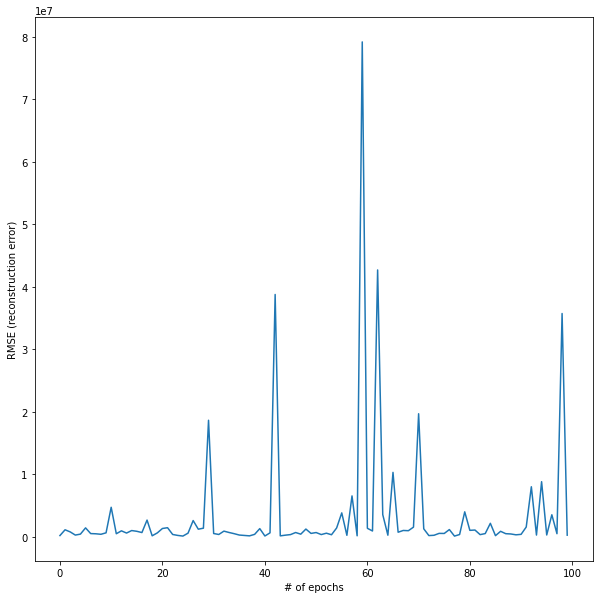

In [22]:
plt.figure(figsize=(10, 10))
plt.plot(np.arange(0,epoch), accum_rms)
plt.xlabel('# of epochs')
plt.ylabel('RMSE (reconstruction error)')
plt.show()

In [23]:
min(accum_rms)

116067.14284366588

In [24]:
np.where(accum_rms==min(accum_rms))

(array([77], dtype=int64),)

In [16]:
a,=np.where(accum_rms==min(accum_rms))
a%1000

array([66, 67, 68], dtype=int64)

In [17]:
store_sensor[197]

IndexError: list index out of range

# 1D Covnet no sigmoid

In [38]:
#define a CNN model
import torch
from torch.nn import Module
from torch.nn import Conv1d
from torch.nn import Linear
from torch.nn import MaxPool2d
from torch.nn import ReLU
from torch.nn import LogSigmoid
from torch import flatten
from torch import nn
import torch.nn.functional as F
EPS = 1e-9





class Simple1DCNN(torch.nn.Module):
    def __init__(self):
        super(Simple1DCNN, self).__init__()
        self.conv1 = torch.nn.Conv1d(in_channels=8000, out_channels=20, kernel_size=1, stride=2)
        #self.bn1 = nn.BatchNorm1d(20) 
        self.act1 = torch.nn.ReLU()
        self.conv2 = torch.nn.Conv1d(in_channels=20, out_channels=40, kernel_size=1)
        #self.bn2 = nn.BatchNorm1d(80)
        self.fc = Linear(in_features=40, out_features=8000)
       
        #self.Sigmoid = torch.nn.Sigmoid()
        
    def forward(self, x):
        x = self.conv1(x)
        #x = self.bn1(x)
        x = self.act1(x)
        x = self.conv2(x)
        #x = self.bn2(x)
        x = flatten(x, 1)
        #x = self.fc(x)
        output = self.fc(x.view(x.size(0), -1))
        
        #output = torch.clamp(output, EPS, 1. - EPS)
        
        

        return output

net = Simple1DCNN().double()

#model = Simple1DCNN().double()

In [39]:
#define loss function

def my_loss(output):
    loss = torch.log(output)
    return loss

In [40]:
#Optimizer and initialize gradient
import torch.optim as optim
opt = optim.SGD(net.parameters(), lr=0.001)

## Training


timestep=0
epoch = 1000
accum_rms=[]
store_sensor=[]
discount=0.001

for i in range(0,epoch):
    
    #Get timetable at timestep

    
    ttable=np.array(X[:,timestep])
    

    #Normalize timetable and convert to tensor
    
    input_tensor = np.dstack((ttable/np.max(ttable)))
    in_tensor = input_tensor.reshape(1,8000,1)
    
    data_cnn=torch.from_numpy(in_tensor.T)
    
    opt.zero_grad()
    
    output = net(data_cnn)
    
    o = output.detach().numpy()
    
    o=o.reshape(8000,)
    
    rank=rankdata(o, method='ordinal')-1
    
    
    store_sensor.append(rank)
    
    error = re_constr(X,nEV+1,nEV,psi_r,rank)
    print(np.sqrt(error)) 
    accum_rms.append(np.sqrt(error))
    
    loss = my_loss(output)*discount*(np.sqrt(error))
   
    if i ==0 : loss.retain_grad() 
    loss.sum().backward()
    
    #Switch to full precision
    #net.float()
    #loss.backward()
    opt.step()

   
    
    
    timestep = timestep+1
    if timestep==720 : timestep =0
    
print(accum_rms)    


425452.4148932604
1246474.7547421348
3713855.087979184
978219.3350823958
8882205.53590417
2791046.690251759
262922.26675329637
672873.8187200004
578784.6344646198
1357452.0389521716
115350.01574855408
284067.9704869963
2250448.011338728
97947860.68409316
2575030.142715009
18252665.305883422
936695.0495879634
3756054.2148543973
219039.18801935654
1832896.1749887099
140262.06324562273
486595.40547629463
3954364.229076647
2534424.866209905
1351116.9643767346
1251283.6600102575
1246008.8672880363
267886.56070442713
2008508.3440156113
284500.6370630965
637927.5886007514
1252368.0813030796
590632.1646678401
239297.10720918182
41084566.37224727
350170.56092210254
375107.4774661924
1099956.5664909247
200223.37335639042
568056.2781520743
8024193.051208525
1271040.4177223407
2568314.491129898
154540.01393091495
277185.8372259058
173012.5525464254
453316.47863184166
183227.3579820031
192597.61166018192
814912.7712908483
3842148.2449725755
6248937.7007312905
508398.683427282
3368216.7976411795
110

1045050.4448804411
478075.3683852215
478979.7395426325
162301.44552771485
2587967.153718135
180436.39394919225
287777.76328181283
5487314.658044329
250449.42202399124
199310.86413914585
18048691.575062554
336959.38455001777
137474.77034219648
6000483.847940229
4524801.123893478
396038.40391789936
238532.1648090261
519237.4436419554
9169184.104722748
840250.4050282406
7268955.381665536
986589.1326814274
534829.7462152338
1551242.925008567
233147.02771385762
559562.6604720525
1705407.218723241
78003.2655933899
835643.6119258575
177099.49712000525
555011.8401577675
105890.40111866803
960684.278838545
1009807.3123875705
6245415.635144999
122046.76904886149
608903.8697980699
51116206.899237536
2536158.1429748563
516659.72692882596
2168432.15399074
1077611.7075345644
161844.76662119813
1680909.2149596245
4641865.944676714
759809.1455591493
1468648.3455470537
102689.27325536267
866273.2103780475
5275927.722391969
876093.7883354352
1381171.818862988
8557405.281256104
1763544.5940196877
200471.

5572368.572341322
228938.8466692661
8871213.454164818
1035836.1966475461
379201.5012997075
572674.4370459008
4752369.530645711
414950.30764738517
3294746.4667859287
591623.4833933559
1108049.6065025704
15566430.937904304
919234.3084822372
657576.3065476248
2301936.656347397
644068.8033426075
1449944.130454511
37515966.61690596
716751.7335479795
1308612.575752644
4529286.607575693
1574091.3839890736
75302071.72513972
2346628.9755180078
2829892.8427463267
443241.5723978259
1752922.9632469772
6527646.041703114
1436877.1177190316
1884322.4421182033
837748.4324758506
29458989.563046306
28764141.492034946
644138.095533957
1384499.0821795273
27086299.69841001
4555651.275310083
241800.57550318685
641489.7686683693
2911941.832001214
63163844.593576334
3165935.456768146
1670219.2491031562
571832.3978067014
1122912.9412845876
594084.9308980673
2656471.566473014
514014353.2485835
2097518.7105709706
1141990.2012189506
317158.31628149416
4399801.9703150345
50437299.62265116
673106.388003388
13257283

In [30]:
store_sensor

[array([5505, 3962, 3041, ..., 3356, 5905, 6878], dtype=int64),
 array([6214,   39, 1350, ...,  608, 4499, 5468], dtype=int64),
 array([2541,  237, 4917, ..., 3693,  601, 1691], dtype=int64),
 array([5771, 2720, 1421, ..., 7574, 1702, 4361], dtype=int64),
 array([5684, 2932, 1464, ..., 7560, 1749, 3855], dtype=int64),
 array([5464, 3521, 1575, ..., 7533, 1877, 5878], dtype=int64),
 array([5399, 3423, 1598, ..., 7526, 1918, 5832], dtype=int64),
 array([2443, 7339, 3709, ..., 6843, 4184, 3233], dtype=int64),
 array([2464, 7329, 3867, ..., 6831, 3941, 3282], dtype=int64),
 array([2474, 7330, 4002, ..., 6827, 4216, 3314], dtype=int64),
 array([2593, 7307, 7285, ..., 6796, 3311, 3585], dtype=int64),
 array([2837, 7259, 7233, ..., 6704, 3820, 4423], dtype=int64),
 array([2864, 7255, 7232, ..., 6699, 3985, 4350], dtype=int64),
 array([3012, 7230, 7207, ..., 6662, 6785, 3830], dtype=int64),
 array([3256, 7164, 7169, ..., 6595, 6747, 5079], dtype=int64),
 array([3287, 7215, 7158, ..., 6596, 672

In [31]:
accum_rms

[1080932.2045584167,
 372908.8256675117,
 4680324.938861731,
 335913.0200290121,
 864527.979569311,
 266955.10235162394,
 20708500.27281113,
 568074.3093724361,
 261719.590544447,
 2115235.8078053864,
 5322453.512834852,
 488948.9361018527,
 2409474.5404985044,
 4001784.4482589765,
 624536.9067144223,
 1301942.4675357633,
 401668.9075227733,
 2335873.328692409,
 5066628.803529835,
 3787077.4974164153,
 1640514.5273968622,
 79555097.84946398,
 1032075.6836269455,
 763076.4353914633,
 122781.33602787928,
 325840.9877859279,
 1504166.5430554631,
 381407.4174887079,
 349906.63577937474,
 17116707.70571752,
 739333.8803218997,
 422761.02631841664,
 1360088.221302643,
 934579.8275040614,
 853571.4319864091,
 220081.7214683666,
 343643.9951112198,
 691557.3011899035,
 1689003.6994832973,
 22608456.29235778,
 1628322.8981222245,
 247067.5811718897,
 1284194.3637284788,
 53252015.99803583,
 6209569.1498100655,
 2311163.9394877865,
 551681.0456548982,
 41502563.10201428,
 322146.39728982927,
 31

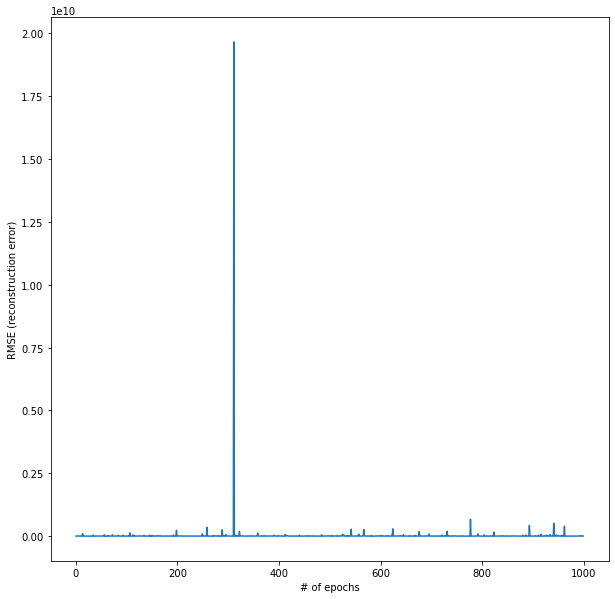

In [41]:
plt.figure(figsize=(10, 10))
plt.plot(np.arange(0,epoch), accum_rms)
plt.xlabel('# of epochs')
plt.ylabel('RMSE (reconstruction error)')
plt.show()

In [42]:
min(accum_rms)

78003.2655933899

In [36]:
g,xr,er = QRPCA(X, nEV+1 , nEV, psi_r , mu)
re_constr(X,nEV+1,nEV,psi_r,g)

current p : 148


21418.98268138028

In [37]:
np.sqrt(re_constr(X,nEV+1,nEV,psi_r,g))

146.35225547076573

# Ploting reconstruction error vs sensor

In [28]:
from numpy.linalg import inv
def QRPCA(data_matrix, p , r, psi_r , meanData):
    # this function assumes that the data_matrix = (# of sensors) X (# of examples) 
    
    print('current p : ' + str(p))
    if p == r:
        Q, R, gamma = LA.qr(psi_r.T, pivoting=True)
        
    elif p > r:
        Q, R, gamma = LA.qr(np.matmul(psi_r,psi_r.T), pivoting=True)
        
    N,M = np.shape(data_matrix) 

    C=np.zeros((p,N))
    
    C[np.arange(len(gamma[:p])), gamma[:p].T] = 1
        
    A = np.matmul( C , psi_r )
    y = np.matmul(C , data_matrix) # y is p-dimensional
    
    
    if p == r:
      a_hat = np.matmul(inv(A),y)    
    elif p > r:
      A_dagger = np.matmul( inv( np.matmul(A.T, A) ), A.T) 
      a_hat    = np.matmul(A_dagger,y)
        
    x_r = np.matmul( psi_r , a_hat )
    
    return gamma,x_r,np.mean((data_matrix-x_r)**2)

In [101]:
nEV

147

In [102]:
g,xr,er = QRPCA(X, 8000 , nEV, psi_r , mu)

current p : 8000


In [103]:
minFeatures = nEV
maxFeatures = 8000
origFeatures = 8000
idx = 0
fCountArray = np.arange(minFeatures, maxFeatures + 1)
mse = np.zeros_like( fCountArray)
diffLength = np.ones_like( fCountArray)

for fCount in fCountArray:
  mse[idx] = re_constr(X, fCount , nEV, psi_r, g )
#  gamma =g[:fCount]
#  g100idx = gamma >= origFeatures
#  gamma[ g100idx ] = gamma[ g100idx ] - origFeatures
# diffLength[ idx] = len(gamma) - len(np.unique(gamma))
  idx = idx + 1

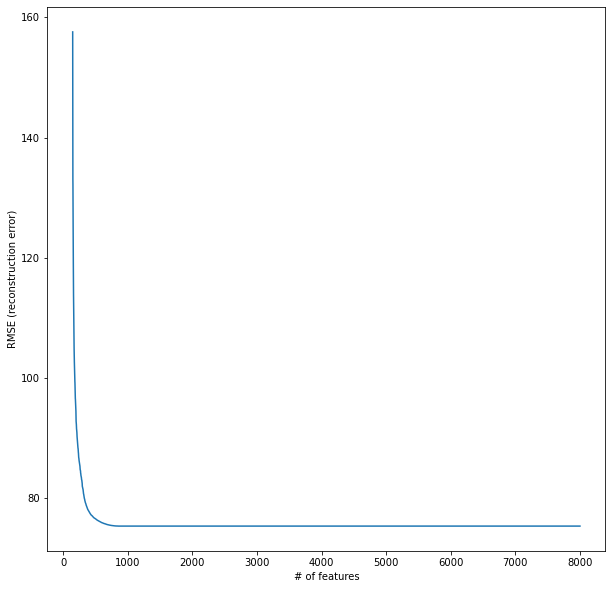

In [104]:
plt.figure(figsize=(10, 10))
plt.plot( fCountArray, np.sqrt(mse))
plt.xlabel('# of features')
plt.ylabel('RMSE (reconstruction error)')
plt.show()

In [116]:
np.where(mse==min(mse))

(array([ 705,  706,  707, ..., 7851, 7852, 7853], dtype=int64),)

In [119]:
min(np.sqrt(mse))


75.34586916347837

In [190]:
stored_sensor =np.copy(store_sensor)
stored_error = np.copy(accum_rms)


In [105]:
store_sensor

[array([3090, 5818, 7105, ..., 1976, 6400, 7147], dtype=int64),
 array([3184, 5757, 7102, ..., 2046, 6344, 7127], dtype=int64),
 array([3302, 5703, 7080, ..., 2073, 6310, 7107], dtype=int64),
 array([3424, 5625, 7053, ..., 2143, 6270, 7089], dtype=int64),
 array([3509, 5619, 7037, ..., 2180, 6221, 7067], dtype=int64),
 array([3728, 5504, 6999, ..., 2278, 6199, 7078], dtype=int64),
 array([3962, 5448, 6979, ..., 2368, 6137, 7044], dtype=int64),
 array([5033, 5396, 6954, ..., 2438, 6102, 7024], dtype=int64),
 array([4947, 5344, 6939, ..., 2498, 6068, 6999], dtype=int64),
 array([4860, 5281, 6909, ..., 2575, 6017, 6968], dtype=int64),
 array([4824, 5209, 6882, ..., 2580, 5968, 6936], dtype=int64),
 array([4885, 5187, 6868, ..., 2628, 6048, 6912], dtype=int64),
 array([4782, 5151, 6837, ..., 2684, 6049, 6889], dtype=int64),
 array([4672, 5092, 6814, ..., 2754, 6027, 6866], dtype=int64),
 array([4554, 5013, 6794, ..., 2782, 5986, 6841], dtype=int64),
 array([4382, 4937, 6758, ..., 2844, 593

array([2811,  173,  152, ..., 1631, 5959, 6326], dtype=int32)

In [148]:
minFeatures = nEV+1
maxFeatures = 8000
origFeatures = 8000
idx = 0
fCountArray = np.arange(minFeatures, maxFeatures + 1)
mseRL = np.zeros_like( fCountArray)

for fCount in fCountArray:
  mseRL[idx] = re_constr(X, fCount , nEV, psi_r, store_sensor[1] )
#  gamma =g[:fCount]
#  g100idx = gamma >= origFeatures
#  gamma[ g100idx ] = gamma[ g100idx ] - origFeatures
# diffLength[ idx] = len(gamma) - len(np.unique(gamma))
  idx = idx + 1

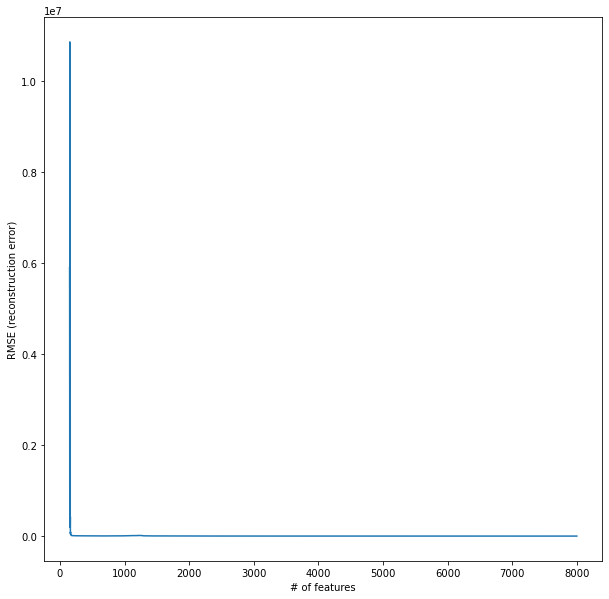

In [149]:
plt.figure(figsize=(10, 10))
plt.plot( fCountArray, np.sqrt(mseRL))
plt.xlabel('# of features')
plt.ylabel('RMSE (reconstruction error)')
plt.show()

In [150]:

np.where(mse==min(mseRL))

(array([ 705,  706,  707, ..., 7851, 7852, 7853], dtype=int64),)

In [151]:

np.where(mse==min(mse))

(array([ 705,  706,  707, ..., 7851, 7852, 7853], dtype=int64),)

In [163]:
print(min(mse))
print(min(mseRL))


5677
5677


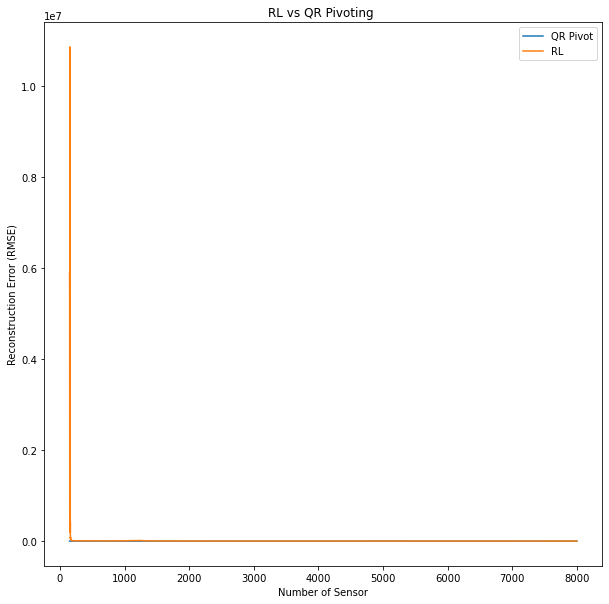

In [160]:
minFeatures = nEV
maxFeatures = 8000

fCountArray = np.arange(minFeatures, maxFeatures + 1)
import matplotlib.pyplot as plt
# line 1 points
plt.figure(figsize=(10, 10))

# plotting the line 1 points 
plt.plot(fCountArray[1:], np.sqrt(mse[1:]), label = "QR Pivot")
# line 2 points

# plotting the line 2 points 
plt.plot(fCountArray[1:], np.sqrt(mseRL), label = "RL")
plt.xlabel('Number of Sensor')
# Set the y axis label of the current axis.
plt.ylabel('Reconstruction Error (RMSE)')
# Set a title of the current axes.
plt.title('RL vs QR Pivoting ')
# show a legend on the plot
plt.legend()
# Display a figure.
plt.show()

(7989, 2)

ValueError: x and y must have same first dimension, but have shapes (63,) and (100,)

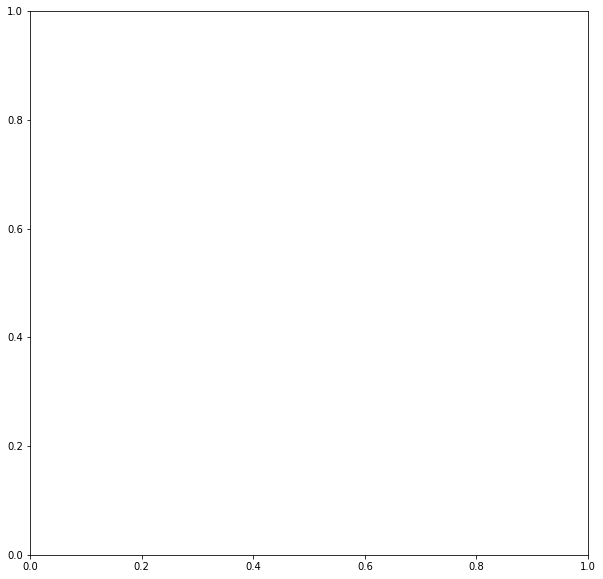

In [418]:
plt.figure(figsize=(10, 10))
plt.plot( fCountArray, np.sqrt(stored_error))
plt.xlabel('# of features')
plt.ylabel('RMSE (reconstruction error)')
plt.show()

In [304]:
np.where(mseRL==min(mseRL))

(array([62], dtype=int64),)

In [433]:
import sys
sys.executable

'C:\\Program Files (x86)\\Microsoft Visual Studio\\Shared\\Anaconda3_64\\python.exe'

In [435]:
!conda install ipykernel --name Python3


EnvironmentLocationNotFound: Not a conda environment: C:\Users\phamhoad\AppData\Local\conda\conda\envs\Python3



23


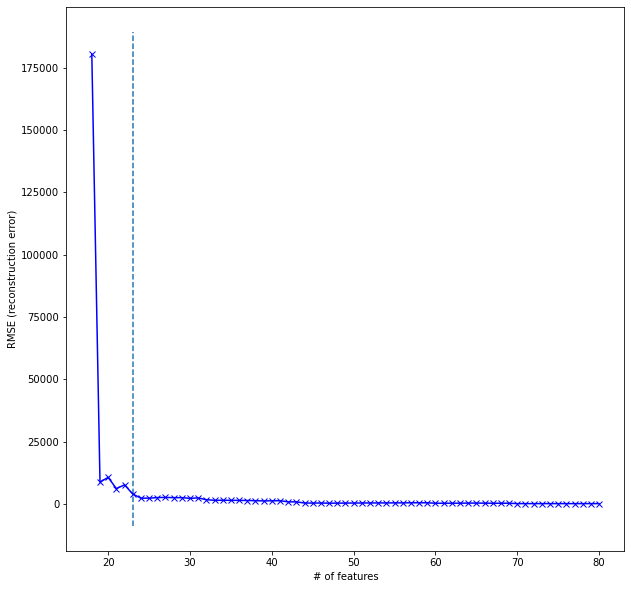

In [25]:
from kneed import KneeLocator
kn = KneeLocator(fCountArray, np.sqrt(mseRL), curve='convex', direction='decreasing',interp_method='interp1d',online=True)
print(kn.knee)

import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
plt.xlabel('# of features')
plt.ylabel('RMSE (reconstruction error)')
plt.plot(fCountArray, np.sqrt(mseRL), 'bx-')
plt.vlines(kn.knee, plt.ylim()[0], plt.ylim()[1], linestyles='dashed')

# Floyd Warshall Algorithm

In [27]:
# Python Program for Floyd Warshall Algorithm
 
# Number of vertices in the graph
V = 25
 
# Define infinity as the large
# enough value. This value will be
# used for vertices not connected to each other
INF = 99999
 
# Solves all pair shortest path
# via Floyd Warshall Algorithm
 
def floydWarshall(graph):
   
    """ dist[][] will be the output
       matrix that will finally
        have the shortest distances
        between every pair of vertices """
    """ initializing the solution matrix
    same as input graph matrix
    OR we can say that the initial
    values of shortest distances
    are based on shortest paths considering no
    intermediate vertices """
 
    dist = list(map(lambda i: list(map(lambda j: j, i)), graph))
 
    """ Add all vertices one by one
    to the set of intermediate
     vertices.
     ---> Before start of an iteration,
     we have shortest distances
     between all pairs of vertices
     such that the shortest
     distances consider only the
     vertices in the set
    {0, 1, 2, .. k-1} as intermediate vertices.
      ----> After the end of a
      iteration, vertex no. k is
     added to the set of intermediate
     vertices and the
    set becomes {0, 1, 2, .. k}
    """
    for k in range(V):
 
        # pick all vertices as source one by one
        for i in range(V):
 
            # Pick all vertices as destination for the
            # above picked source
            for j in range(V):
 
                # If vertex k is on the shortest path from
                # i to j, then update the value of dist[i][j]
                dist[i][j] = min(dist[i][j],
                                 dist[i][k] + dist[k][j]
                                 )
#    printSolution(dist)
    return dist

# A utility function to print the solution
def printSolution(dist):
    print ("Following matrix shows the shortest distances\
 between every pair of vertices")
    for i in range(V):
        for j in range(V):
            if(dist[i][j] == INF):
                print ("%7s" % ("INF"),end=" ")
            else:
                print ("%7d\t" % (dist[i][j]),end=' ')
            if j == V-1:
                print ()
 
 
# Driver program to test the above program
# Let us create the following weighted graph


In [132]:
linknodelist

{(2044, 3223): 0,
 (3223, 2427): 1,
 (2427, 3619): 2,
 (3619, 2822): 3,
 (2822, 4): 4,
 (4, 3231): 5,
 (3231, 385): 6,
 (385, 2286): 7,
 (2286, 3477): 8,
 (3477, 631): 9,
 (631, 3859): 10,
 (3859, 1026): 11,
 (1026, 244): 12,
 (244, 1429): 13,
 (1429, 639): 14,
 (639, 1811): 15,
 (1811, 1035): 16,
 (1035, 2198): 17,
 (2198, 3377): 18,
 (3377, 1282): 19,
 (1282, 2440): 20,
 (2440, 1671): 21,
 (1671, 2834): 22,
 (2834, 2063): 23,
 (2063, 3241): 24,
 (3241, 2447): 25,
 (2447, 3637): 26,
 (3637, 2845): 27,
 (2845, 24): 28,
 (24, 1191): 29,
 (1191, 3096): 30,
 (3096, 258): 31,
 (258, 3491): 32,
 (3491, 650): 33,
 (650, 3876): 34,
 (3876, 1047): 35,
 (1047, 267): 36,
 (267, 1448): 37,
 (1448, 2594): 38,
 (2594, 1835): 39,
 (1835, 2996): 40,
 (2996, 903): 41,
 (903, 2073): 42,
 (2073, 1297): 43,
 (1297, 2460): 44,
 (2460, 1693): 45,
 (1693, 2856): 46,
 (2856, 35): 47,
 (35, 3263): 48,
 (3263, 420): 49,
 (420, 2318): 50,
 (2318, 3508): 51,
 (3508, 2705): 52,
 (2705, 3887): 53,
 (3887, 3116): 5

1901

In [137]:
# return Adj matrix with zeros between and INF for unconnected node
def sensor_matrix_inf(sen_array):
    sen_matrix =np.ones((No_Node,No_Node))*INF


    
    for i in range(No_Node):
        nnodes=nextnodelist8kl[i][0]
        for k in nnodes:
            
            j= linknodelist[(i,k)]
            sen_matrix[i][k]=sen_array[j]
            
        sen_matrix[i][i]=0
    return sen_matrix

In [136]:
nextnodelist8kl


0       [[1173, 2818]]
1       [[1171, 2819]]
2       [[3229, 2820]]
3       [[3230, 2821]]
4       [[3231, 2822]]
             ...      
3980     [[1155, 765]]
3981     [[463, 2181]]
3982      [[225, 770]]
3983      [[226, 771]]
3984     [[470, 2187]]
Length: 3985, dtype: object

In [148]:
X[:,700]

array([1.61501606e+00, 9.00000000e+02, 9.00000000e+02, ...,
       7.69230769e-01, 7.69230769e-01, 7.69230769e-01])

In [150]:
sensor_matrix(X[:,0])

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [138]:
tg=sensor_matrix_inf(X[:,0])

In [155]:
tg[0][1173]

0.7692307692307693

In [140]:
a= floydWarshall(tg)
a= np.array(a)
print(a)

[[    0. 99999. 99999. ... 99999. 99999. 99999.]
 [99999.     0. 99999. ... 99999. 99999. 99999.]
 [99999. 99999.     0. ... 99999. 99999. 99999.]
 ...
 [99999. 99999. 99999. ...     0. 99999. 99999.]
 [99999. 99999. 99999. ... 99999.     0. 99999.]
 [99999. 99999. 99999. ... 99999. 99999.     0.]]


In [156]:
a[0][1173]

0.7692307692307693

In [141]:
printSolution(a)

Following matrix shows the shortest distances between every pair of vertices
      0	     INF     INF     INF     INF     INF     INF     INF     INF     INF     INF     INF     INF     INF     INF     INF     INF     INF     INF     INF     INF     INF     INF     INF     INF 
    INF       0	     INF     INF     INF     INF     INF     INF     INF     INF     INF     INF     INF     INF     INF     INF     INF     INF     INF     INF     INF     INF     INF     INF     INF 
    INF     INF       0	     INF     INF     INF     INF     INF     INF     INF     INF     INF     INF     INF     INF     INF     INF     INF     INF     INF     INF     INF     INF     INF     INF 
    INF     INF     INF       0	     INF     INF     INF     INF     INF     INF     INF     INF     INF     INF     INF     INF     INF     INF     INF     INF     INF     INF     INF     INF     INF 
    INF     INF     INF     INF       0	     INF     INF     INF     INF     INF     INF     INF     INF     INF   

In [160]:
tg1=sensor_matrix_inf(X[:,0])
a= floydWarshall(tg1)
a= np.array(a)
tg2=sensor_matrix_inf(X[:,100])
b= floydWarshall(tg2)
b= np.array(b)
np.mean((a-b)**2)

5.362234025404541

In [67]:
tgg=tg / LA.norm(tg)
floydWarshall(tgg)

[[0.0,
  6.421443393525804e-05,
  0.00012999443182017714,
  0.00019577442970509625,
  0.00026155442759001537,
  6.577999788491911e-05,
  0.00012999443182017714,
  0.00019577442970509625,
  0.00026150618892489976,
  0.0003272861868098189,
  0.00013155999576983823,
  0.00019577442970509625,
  0.00026155442759001537,
  0.0003272861868098189,
  0.000393066184694738,
  0.00019733999365475734,
  0.00026155442759001537,
  0.00032733442547493445,
  0.0003923601460507732,
  0.00045814014393569236,
  0.00026311999153967645,
  0.00032733442547493445,
  0.00039311442335985354,
  0.00045814014393569236,
  0.0005239201418206114],
 [6.577999788491911e-05,
  0.0,
  6.577999788491911e-05,
  0.00013155999576983823,
  0.00019733999365475734,
  0.00013155999576983823,
  6.577999788491911e-05,
  0.00013155999576983823,
  0.00019729175498964173,
  0.00026307175287456085,
  0.00019448514174655185,
  0.00013155999576983823,
  0.00019733999365475734,
  0.00026307175287456085,
  0.00032885175075948,
  0.0002602

In [74]:
def compare_SP(Adj_matrix1, Adj_matrix2, with_norm=False):
    if with_norm:
        a= np.array(floydWarshall(Adj_matrix1/LA.norm(Adj_matrix1)))
        b= np.array(floydWarshall(Adj_matrix2/LA.norm(Adj_matrix2)))
    else:
        a= np.array(floydWarshall(Adj_matrix1))
        b= np.array(floydWarshall(Adj_matrix2))
    return np.mean((a-b)**2)



In [76]:
compare_SP(sensor_matrix_inf(traveltime[1]),sensor_matrix_inf(traveltime[2]),with_norm=True)

4.98065918331608e-13

In [88]:
X

array([[149.32, 146.43, 142.77, ..., 535.41, 493.86, 460.49],
       [150.  , 150.  , 150.  , ..., 692.1 , 682.35, 643.75],
       [150.  , 150.  , 150.  , ..., 149.55, 147.87, 146.41],
       ...,
       [150.  , 150.  , 150.  , ..., 145.04, 145.5 , 146.28],
       [150.  , 150.  , 150.  , ..., 147.07, 144.71, 147.56],
       [150.  , 150.  , 150.  , ..., 150.  , 150.  , 150.  ]])

In [110]:
#Reconsrtruction return SP error
#def re_constr_SP(data_matrix,p,r,psi_r,gamma):
    
    
#    N,M = np.shape(data_matrix) 

#    C=np.zeros((p,N))
    
#    C[np.arange(len(gamma[:p])), gamma[:p].T] = 1
        
#    A = np.matmul( C , psi_r )
#    y = np.matmul(C , data_matrix) # y is p-dimensional
    
    
#    if p == r:
#      a_hat = np.matmul(inv(A),y)    
#    elif p > r:
#      A_dagger = np.matmul( inv( np.matmul(A.T, A) ), A.T) 
#      a_hat    = np.matmul(A_dagger,y)
        
#    x_r = np.matmul( psi_r , a_hat )
    
#    return compare_SP(data_matrix,x_r,with_norm=True)
    #return x_r

In [260]:
#Reconsrtruction return reconstructed matrix
def re_constr_mt(data_matrix,p,r,psi_r,gamma):
    
    
    N,M = np.shape(data_matrix) 

    C=np.zeros((p,N))
    
    C[np.arange(len(gamma[:p])), gamma[:p].T] = 1
        
    A = np.matmul( C , psi_r )
    y = np.matmul(C , data_matrix) # y is p-dimensional
    
    
    if p == r:
      a_hat = np.matmul(inv(A),y)    
    elif p > r:
      A_dagger = np.matmul( inv( np.matmul(A.T, A) ), A.T) 
      a_hat    = np.matmul(A_dagger,y)
        
    x_r = np.matmul( psi_r , a_hat )
    
    
    return x_r

In [388]:
r_x=re_constr_mt(X, 20 , nEV, psi_r, g )

In [349]:
a1= sensor_matrix_inf(traveltime[0])
a2= sensor_matrix_inf(traveltime[1])
aa=np.append([a1],[a2],axis=0)
np.shape(aa)

(2, 25, 25)

In [350]:
Sen,sam =np.shape(r_x)

In [389]:
ar=[]
for i in range(sam):
     
    ar.append(np.array(floydWarshall(sensor_matrix_inf(r_x[:,i])/LA.norm(sensor_matrix_inf(r_x[:,i])))))

ar =np.array(ar)
np.shape(ar)

(720, 25, 25)

(720, 25, 25)


numpy.ndarray

In [383]:
arX=[]
for i in range(sam):
     
    arX.append(np.array(floydWarshall(sensor_matrix_inf(X[:,i])/LA.norm(sensor_matrix_inf(X[:,i])))))

arX =np.array(arX)
np.shape(arX)

(720, 25, 25)

In [384]:
trailmse= ((arX-ar)**2)

In [390]:
np.sqrt(np.average(((arX-ar)**2)))

1542168203.243415

In [272]:
acc_error=[]
for i in range(sam):
    tem_error = np.mean((sensor_matrix(r_x[:,i])-X[:,i])**2)
    acc_error.append(tem_error)

In [283]:
xx=floydWarshall(sensor_matrix_inf(r_x[:,i]))
xxx=np.array(xx)
np.shape(xxx)

(25, 25)

In [286]:
# return average error between data and reconstructed data by slicing each sample of data, convert to all pair SP 
# and take MSE

def avg_error(A,B,with_norm=True):
    sen,sam = np.shape(r_x)
    all_error =[]

    for i in range(sam):
        Adj_A = sensor_matrix_inf(A[:,i])
        Adj_B = sensor_matrix_inf(B[:,i])
        
        
        ASP_A=np.array(floydWarshall(Adj_A/LA.norm(Adj_A)))
       
        ASP_B=np.array(floydWarshall(Adj_B/LA.norm(Adj_B)))
        
        tem_error = np.mean((ASP_A-ASP_B)**2)
        all_error.append(tem_error)
    return np.average(all_error)
    

In [392]:
# return average error between data and reconstructed data by slicing each sample of data, convert to all pair SP 
# and take MSE but Faster

def get_tensor_matrix(a):
    _,d =np.shape(a)
    ary=[]
    for i in range(d):
     
        ary.append(np.array(floydWarshall(sensor_matrix_inf(a[:,i])/LA.norm(sensor_matrix_inf(a[:,i])))))

    return np.array(ary)
    

    

In [394]:
np.sqrt(avg_error(r_x,X))

1542168203.243415

In [290]:
#reconstruction return average SP error (ASPE)

def re_constr_ASPE(data_matrix,p,r,psi_r,gamma):
    
    
    N,M = np.shape(data_matrix) 

    C=np.zeros((p,N))
    
    C[np.arange(len(gamma[:p])), gamma[:p].T] = 1
        
    A = np.matmul( C , psi_r )
    y = np.matmul(C , data_matrix) # y is p-dimensional
    
    
    if p == r:
      a_hat = np.matmul(inv(A),y)    
    elif p > r:
      A_dagger = np.matmul( inv( np.matmul(A.T, A) ), A.T) 
      a_hat    = np.matmul(A_dagger,y)
        
    x_r = np.matmul( psi_r , a_hat )
    

    return avg_error(data_matrix,x_r)
    #return x_r

In [393]:
#reconstruction return average SP error (ASPE) but faster

def re_constr_ASPE_faster(data_matrix,p,r,psi_r,gamma):
    
    
    N,M = np.shape(data_matrix) 

    C=np.zeros((p,N))
    
    C[np.arange(len(gamma[:p])), gamma[:p].T] = 1
        
    A = np.matmul( C , psi_r )
    y = np.matmul(C , data_matrix) # y is p-dimensional
    
    
    if p == r:
      a_hat = np.matmul(inv(A),y)    
    elif p > r:
      A_dagger = np.matmul( inv( np.matmul(A.T, A) ), A.T) 
      a_hat    = np.matmul(A_dagger,y)
        
    x_r = np.matmul( psi_r , a_hat )
    

    return np.mean((get_tensor_matrix(data_matrix)-get_tensor_matrix(x_r))**2)
    #return x_r

In [398]:
np.sqrt(re_constr_ASPE(X, 20 , nEV, psi_r, g))


1542168203.243415

In [399]:
np.sqrt(re_constr_ASPE_faster(X, 20 , nEV, psi_r, g))

1542168203.243415

In [291]:
##SHORTEST PATH ERROR

minFeatures = nEV
maxFeatures = 80
origFeatures = 80
idx = 0
fCountArray = np.arange(minFeatures, maxFeatures + 1)
SPmse = np.zeros_like( fCountArray,dtype=np.float64)
diffLength = np.ones_like( fCountArray)

for fCount in fCountArray:
  SPmse[idx] = re_constr_ASPE(X, fCount , nEV, psi_r, g )
#  gamma =g[:fCount]
#  g100idx = gamma >= origFeatures
#  gamma[ g100idx ] = gamma[ g100idx ] - origFeatures
# diffLength[ idx] = len(gamma) - len(np.unique(gamma))
  idx = idx + 1
    
idx = 0

SPmseRL = np.zeros_like( fCountArray,dtype=np.float64)


for fCount in fCountArray:
  SPmseRL[idx] = re_constr_ASPE(X, fCount , nEV, psi_r, store_sensor[1] )
#  gamma =g[:fCount]
#  g100idx = gamma >= origFeatures
#  gamma[ g100idx ] = gamma[ g100idx ] - origFeatures
# diffLength[ idx] = len(gamma) - len(np.unique(gamma))
  idx = idx + 1

In [292]:
np.where(np.sqrt(SPmse)==min(np.sqrt(SPmse)))


(array([62], dtype=int64),)

In [294]:
np.sqrt(SPmse[62])

1351029266.7240937

In [296]:
np.where(np.sqrt(SPmseRL)==min(np.sqrt(SPmseRL)))

(array([56], dtype=int64),)

In [297]:
np.sqrt(SPmseRL[56])

34865.44932441437

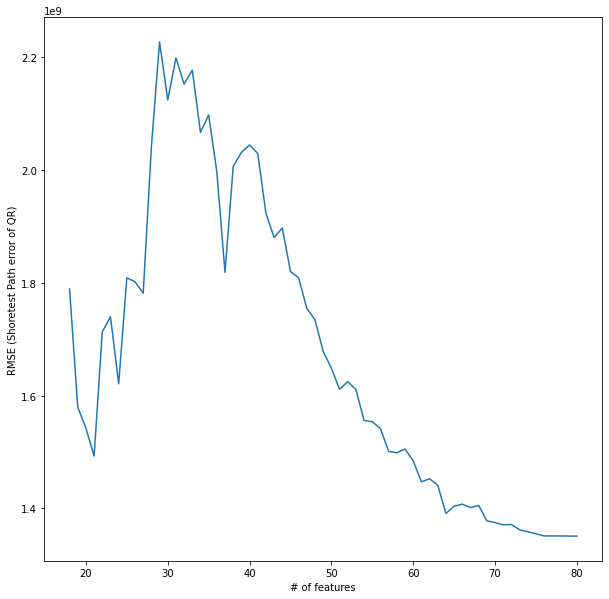

In [298]:
plt.figure(figsize=(10, 10))
plt.plot( fCountArray, np.sqrt(SPmse))
plt.xlabel('# of features')
plt.ylabel('RMSE (Shoretest Path error of QR)')
plt.show()

In [140]:
np.where(np.sqrt(SPmseRL)==min(np.sqrt(SPmseRL)))
np.sqrt(SPmseRL[56])

156837.3377749445

In [153]:
fCountArray

array([18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68,
       69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80], dtype=int64)

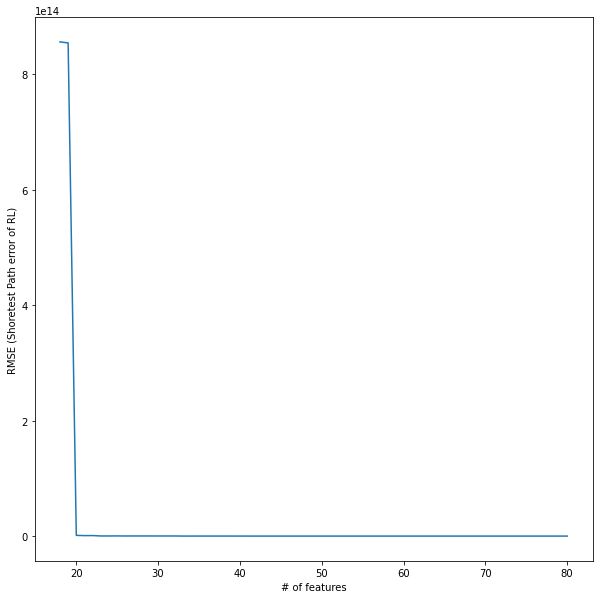

In [299]:
plt.figure(figsize=(10, 10))
plt.plot( fCountArray, np.sqrt(SPmseRL))
plt.xlabel('# of features')
plt.ylabel('RMSE (Shoretest Path error of RL)')
plt.show()

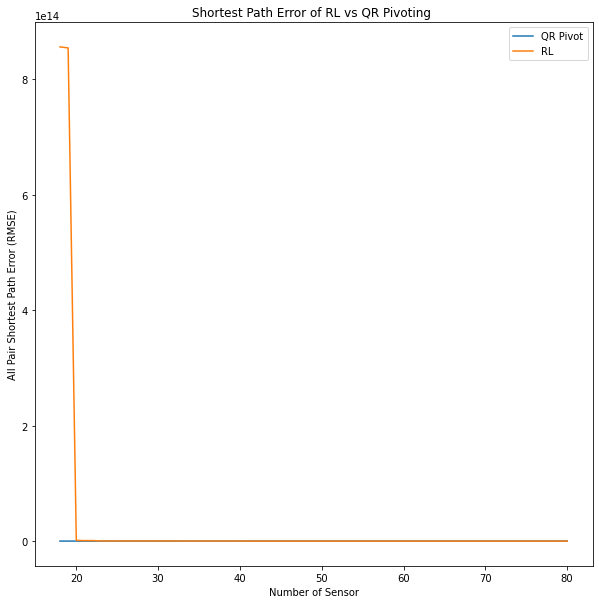

In [300]:
import matplotlib.pyplot as plt
# line 1 points
plt.figure(figsize=(10, 10))

# plotting the line 1 points 
plt.plot(fCountArray, np.sqrt(SPmse), label = "QR Pivot")
# line 2 points

# plotting the line 2 points 
plt.plot(fCountArray, np.sqrt(SPmseRL), label = "RL")
plt.xlabel('Number of Sensor')
# Set the y axis label of the current axis.
plt.ylabel('All Pair Shortest Path Error (RMSE)')
# Set a title of the current axes.
plt.title('Shortest Path Error of RL vs QR Pivoting ')
# show a legend on the plot
plt.legend()
# Display a figure.
plt.show()

In [156]:
len(fCountArray)

63

In [304]:
min_x = np.argmin(np.sqrt(SPmse))
min_y = np.min(np.sqrt(SPmse))
min_xrl = np.argmin(np.sqrt(SPmseRL))
min_yrl = np.min(np.sqrt(SPmseRL))

In [305]:
print(min_x)
print(min_xrl)

62
56


In [329]:
print(min_x+nEV)
print(min_xrl+nEV)

80
74


In [322]:
store_sensor[1]
unique, counts = np.unique(store_sensor[1], return_counts=True)
dict(zip(unique, counts))

{0: 1,
 1: 1,
 2: 1,
 3: 1,
 4: 1,
 5: 1,
 6: 1,
 7: 1,
 8: 1,
 9: 1,
 10: 1,
 11: 1,
 12: 1,
 13: 1,
 14: 1,
 15: 1,
 16: 1,
 17: 1,
 18: 1,
 19: 1,
 20: 1,
 21: 1,
 22: 1,
 23: 1,
 24: 1,
 25: 1,
 26: 1,
 27: 1,
 28: 1,
 29: 1,
 30: 1,
 31: 1,
 32: 1,
 33: 1,
 34: 1,
 35: 1,
 36: 1,
 37: 1,
 38: 1,
 39: 1,
 40: 1,
 41: 1,
 42: 1,
 43: 1,
 44: 1,
 45: 1,
 46: 1,
 47: 1,
 48: 1,
 49: 1,
 50: 1,
 51: 1,
 52: 1,
 53: 1,
 54: 1,
 55: 1,
 56: 1,
 57: 1,
 58: 1,
 59: 1,
 60: 1,
 61: 1,
 62: 1,
 63: 1,
 64: 1,
 65: 1,
 66: 1,
 67: 1,
 68: 1,
 69: 1,
 70: 1,
 71: 1,
 72: 1,
 73: 1,
 74: 1,
 75: 1,
 76: 1,
 77: 1,
 78: 1,
 79: 1}

In [323]:
unique, counts = np.unique(g, return_counts=True)
dict(zip(unique, counts))

{0: 1,
 1: 1,
 2: 1,
 3: 1,
 4: 1,
 5: 1,
 6: 1,
 7: 1,
 8: 1,
 9: 1,
 10: 1,
 11: 1,
 12: 1,
 13: 1,
 14: 1,
 15: 1,
 16: 1,
 17: 1,
 18: 1,
 19: 1,
 20: 1,
 21: 1,
 22: 1,
 23: 1,
 24: 1,
 25: 1,
 26: 1,
 27: 1,
 28: 1,
 29: 1,
 30: 1,
 31: 1,
 32: 1,
 33: 1,
 34: 1,
 35: 1,
 36: 1,
 37: 1,
 38: 1,
 39: 1,
 40: 1,
 41: 1,
 42: 1,
 43: 1,
 44: 1,
 45: 1,
 46: 1,
 47: 1,
 48: 1,
 49: 1,
 50: 1,
 51: 1,
 52: 1,
 53: 1,
 54: 1,
 55: 1,
 56: 1,
 57: 1,
 58: 1,
 59: 1,
 60: 1,
 61: 1,
 62: 1,
 63: 1,
 64: 1,
 65: 1,
 66: 1,
 67: 1,
 68: 1,
 69: 1,
 70: 1,
 71: 1,
 72: 1,
 73: 1,
 74: 1,
 75: 1,
 76: 1,
 77: 1,
 78: 1,
 79: 1}

In [327]:
SPmseRL[-1]

1.8252800795450445e+18

In [328]:
SPmse[-1]

1.8252800795450424e+18

In [325]:
len(fCountArray)

63

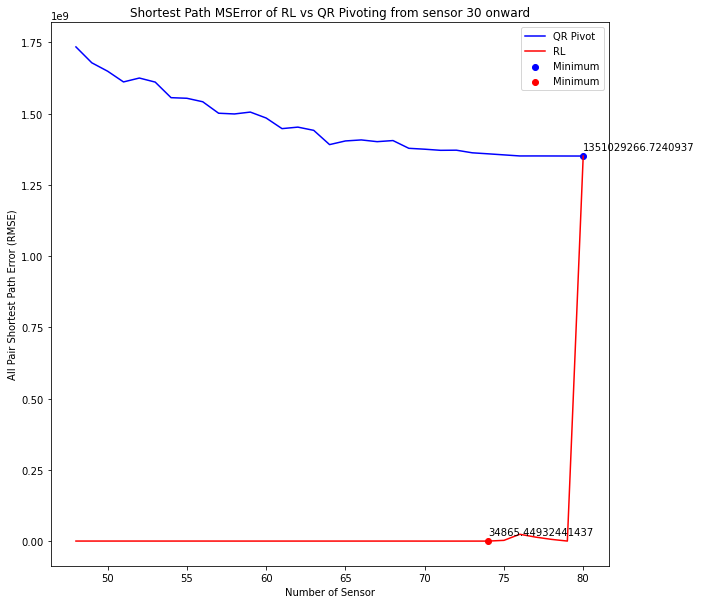

In [326]:
import matplotlib.pyplot as plt
# line 1 points
plt.figure(figsize=(10, 10))
from_sensor=30
# plotting the line 1 points 
plt.plot(fCountArray[from_sensor:], np.sqrt(SPmse[from_sensor:]),c='b', label = "QR Pivot")
# line 2 points
#plt.scatter(fCountArray[from_sensor:],Y_QR,'o')
# plotting the line 2 points 
plt.plot(fCountArray[from_sensor:], np.sqrt(SPmseRL[from_sensor:]),c='r', label = "RL")
plt.xlabel('Number of Sensor')
# Set the y axis label of the current axis.
plt.ylabel('All Pair Shortest Path Error (RMSE)')
# Set a title of the current axes.
plt.title('Shortest Path MSError of RL vs QR Pivoting from sensor 30 onward')
plt.scatter(min_x+nEV, min_y,c='b', label='Minimum')
plt.annotate(min_y, (min_x+nEV, min_y+2e7))

plt.scatter(min_xrl+nEV, min_yrl,c='r', label='Minimum')
plt.annotate(min_yrl, (min_xrl+nEV, min_yrl+2e7))
# show a legend on the plot

plt.legend()
# Display a figure.
plt.show()

In [ ]:
#actually with 60 sensor RL give lower error : 0.03966678536080673
#QR with 70 sensor give lowest error: 9890076.498981252

# Experiment Using Shortest Path error and 